# Loading Necessary Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
!pip install wordcloud
from wordcloud import WordCloud  
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Download necessary NLTK data
nltk.download(['stopwords', 'punkt', 'wordnet', 'omw-1.4', 'vader_lexicon'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Osato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Osato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Osato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Osato\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Osato\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Load dataset
df = pd.read_csv('amazon_reviews.csv')

In [4]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


# Display Basic Information

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB
None


In [7]:
print(df.describe())

        Unnamed: 0      overall     day_diff  helpful_yes   helpful_no  \
count  4915.000000  4915.000000  4915.000000  4915.000000  4915.000000   
mean   2457.000000     4.587589   437.367040     1.311089     0.210376   
std    1418.982617     0.996845   209.439871    41.619161     4.023296   
min       0.000000     1.000000     1.000000     0.000000     0.000000   
25%    1228.500000     5.000000   281.000000     0.000000     0.000000   
50%    2457.000000     5.000000   431.000000     0.000000     0.000000   
75%    3685.500000     5.000000   601.000000     0.000000     0.000000   
max    4914.000000     5.000000  1064.000000  1952.000000   183.000000   

        total_vote  score_pos_neg_diff  score_average_rating  \
count  4915.000000         4915.000000           4915.000000   
mean      1.521465            1.100712              0.075468   
std      44.123095           39.367949              0.256062   
min       0.000000         -130.000000              0.000000   
25%       0.0

In [8]:
print(df.isnull().sum())

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


# Data Cleaning 

In [10]:
# Renaming unmaned to username 
df.rename(columns={'Unnamed: 0': 'userID'}, inplace=True)

In [11]:
# Removing missing values
df = df.dropna(subset=['reviewText', 'reviewerName', 'overall'])

In [12]:
print(df.isnull().sum())

userID                  0
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


In [13]:
# Define stopwords
stop_words = set(stopwords.words('english'))

In [14]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"[^\w\s]", "", text.lower())  # Remove special characters and convert to lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Text Review

In [16]:
review = df['reviewText'][4900]
print(review)

SO I recently got a new Chinese brand Android phone (Inew i4000): Quadcore, 13mp camera, 1GB ram, 16Gb internal storage + MicroSD Support. Also comes with App2SD software support as well.I had an old Samsung Class 10 32GB and tested that it works with the i4000. But wasn't enough for a Power-user like me.Decided to give it the extra storage BOOST!With the Sandisk 64GB Class 10, I now hold within:11GB Music Collection (MP3's at ~192 KBPS)20GB of Graphic Novels/Manga/ManwhaBooks with a Manga App/reader2GB of Apps (migrate the Core apps from internal storage to External storage)8GB of Photos taken with the Phone (uses MicroSD as storage for photos)~30GB of free space left for downloading Movies/MP3s/and documents on-the-goI love this little card, its fantastic and a great way to add some serious expandable storage onto any Smartphone that supports the storage.FYI, I had to format the Sandisk 64GB card using my Smartphone (i4000) in order for it to set the microSD to FAT32. DON'T use the P

In [17]:
tokens = nltk.word_tokenize(review)
tokens[:12]

['SO',
 'I',
 'recently',
 'got',
 'a',
 'new',
 'Chinese',
 'brand',
 'Android',
 'phone',
 '(',
 'Inew']

# WordCloud for Visualization

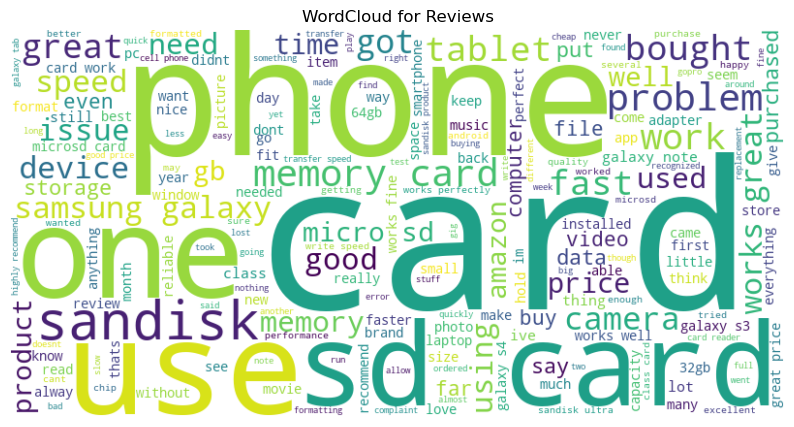

In [19]:
# Apply preprocessing
df['cleaned_review'] = df['reviewText'].apply(preprocess_text)

# WordCloud for visualization
all_words = " ".join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Reviews')
plt.show()

# Test Train and Split

In [21]:
# Train-test split
x = df['cleaned_review']
y = df['overall']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")

Training set size: 3930
Test set size: 983


In [22]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams and bigrams
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

# Class Balancing Using SMOTE

In [24]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)  # will 'auto' balance all classes to the size of the largest class
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_tfidf, y_train)

print(f"Original training set size: {x_train.shape[0]} samples")
print(f"Balanced training set size: {x_train_balanced.shape[0]} samples")

Original training set size: 3930 samples
Balanced training set size: 15705 samples


# Defining Logistic Regression

In [26]:
# Model definition (Logistic Regression)
model = LogisticRegression(max_iter=1000, random_state=42)

In [27]:
from sklearn.model_selection import StratifiedKFold
# Stratified K-Fold Cross-Validation to ensure each fold has similar class distributions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
from sklearn.model_selection import GridSearchCV
# Using GridSearchCV to find the best hyperparameters for Logistic Regression
param_grid = { 'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers that work well with small datasets
    'max_iter': [1000]}  # Increased iteration for convergence

grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(x_train_balanced, y_train_balanced)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

print(f"Best hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best hyperparameters: {'C': 10, 'max_iter': 1000, 'solver': 'saga'}


In [29]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

# Confusion Matrix 

Classification Report:
              precision    recall  f1-score   support

         1.0       0.79      0.20      0.32        54
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        25
         4.0       0.50      0.01      0.02       110
         5.0       0.81      1.00      0.89       780

    accuracy                           0.80       983
   macro avg       0.42      0.24      0.25       983
weighted avg       0.74      0.80      0.73       983

Confusion Matrix:


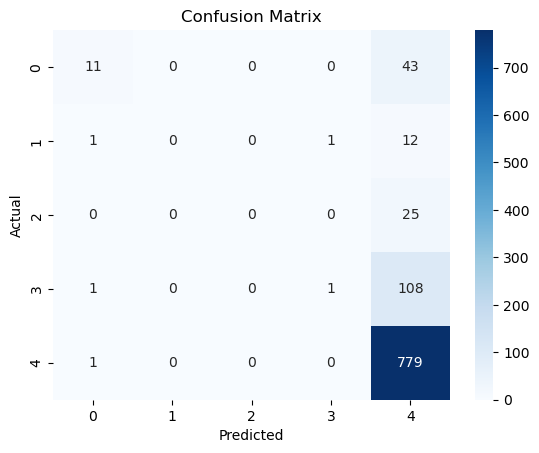

In [31]:
# Predict and evaluate
y_pred = model.predict(x_test_tfidf)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the labels for multiclass classification
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)  # Binarize training labels
y_test_bin = lb.transform(y_test)  # Binarize test labels

# Predict probabilities
y_pred_prob = model.predict_proba(x_test_tfidf)

# Compute ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}

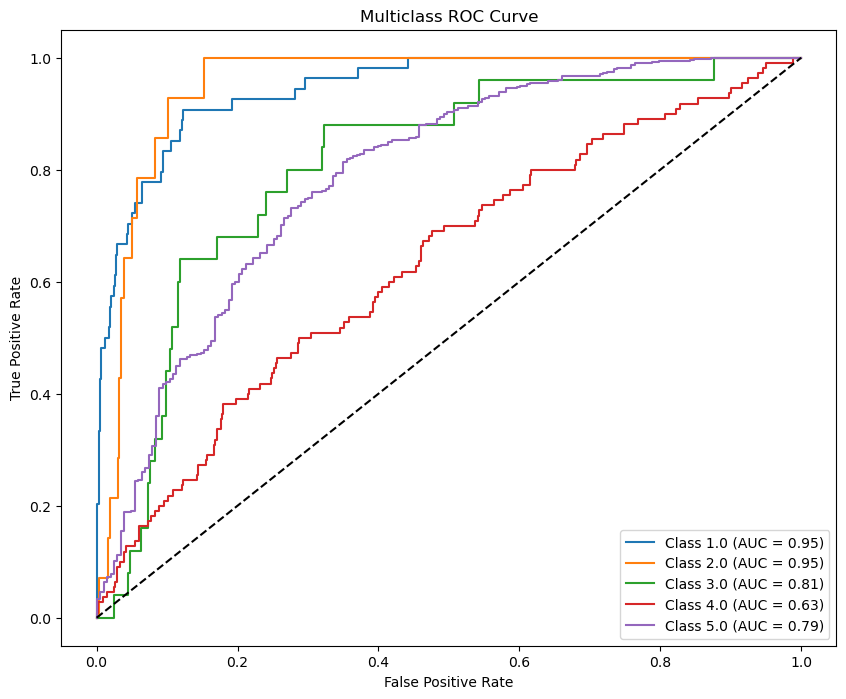

In [33]:
# Iterate over all classes
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Using SentimentIntensityAnalysis (SIA)

In [35]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [36]:
sia

In [37]:
sia.polarity_scores(review)

{'neg': 0.02, 'neu': 0.835, 'pos': 0.146, 'compound': 0.9866}

In [38]:
from tqdm import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df), dynamic_ncols=False, ascii=True):
    text = row['reviewText']
    myusername = row['userID']
    res[myusername] = sia.polarity_scores(text)

100%|##########| 4913/4913 [00:10<00:00, 476.16it/s]


In [39]:
res
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'userID'})
vaders = vaders.merge(df, how='left')

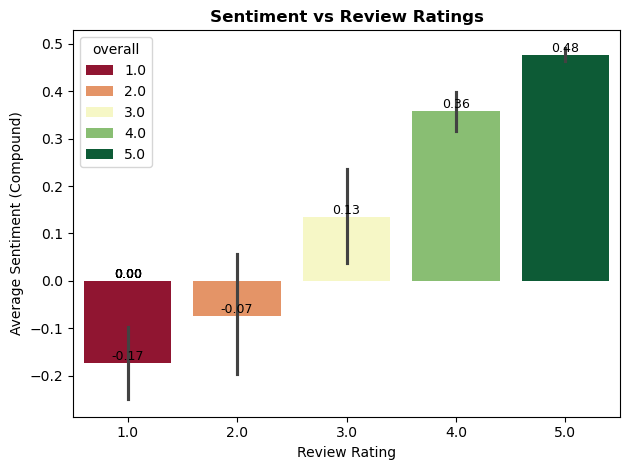

In [40]:
# Enhanced Bar Plot (Concise)
ax = sns.barplot(data=vaders,x='overall',y='compound', hue = 'overall', palette="RdYlGn")

# Adding annotations for bar values
for bar in ax.patches:
    ax.annotate(f"{bar.get_height():.2f}", 
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                ha='center', va='bottom', fontsize=9)

# Adding title and axis labels
ax.set_title('Sentiment vs Review Ratings', fontsize=12, fontweight='bold')
ax.set_xlabel('Review Rating', fontsize=10)
ax.set_ylabel('Average Sentiment (Compound)', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()



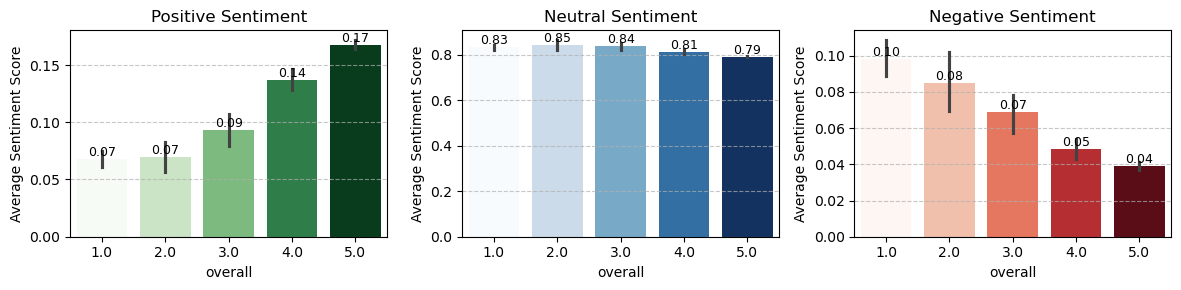

In [41]:
# Enhanced Bar Plots with Fix for FutureWarning
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Create bar plots with custom color palettes and annotations
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0], hue='overall', palette='Greens', legend=False)
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1], hue='overall', palette='Blues', legend=False)
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2], hue='overall', palette='Reds', legend=False)

# Adding titles and labels
axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')

# Adding y-axis label for clarity
for ax in axs:
    ax.set_ylabel('Average Sentiment Score')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Annotate bars with sentiment values
    for bar in ax.patches:
        ax.annotate(f'{bar.get_height():.2f}', 
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='center', va='bottom', fontsize=9)

# Display the plot
plt.tight_layout()
plt.show()